# Bibliotecas

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics  import accuracy_score, precision_score, recall_score ,f1_score, confusion_matrix, roc_curve, auc,roc_auc_score;

# Coleta de Base

Como visto no passo anterior, geramos duas bases de treino uma com dados originais e outra com dados sinteticos (oversampling), e por fim uma base de teste, na qual usaremos para avaliar os modelos.

In [37]:
# Permite que todas as colunas do dataframe sejam apresentadas
pd.set_option('display.max_columns', None)

# Busca as bases de treino e teste
df_train_smote = pd.read_csv('/content/drive/MyDrive/Bases Projetos/2 - Acidentes rodoviária federal - Brasil/train_smote.csv')
df_train = pd.read_csv('https://raw.githubusercontent.com/Muniz97/Federal-road-accidents---Brazil/main/3%20-%20Preprocessing/train_encoder.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Muniz97/Federal-road-accidents---Brazil/main/3%20-%20Preprocessing/test_encoder.csv')

**Obs**: Devido ao tamanho do arquivo de treino com oversampling ele ficará disponivel via Google Drive, pode ser acessado via [link](https://drive.google.com/file/d/1e752rs0m0TtbauWc9HEw57Bwd5BSPHYV/view?usp=sharing) ou replicando o passo a passo que realizei neste projeto.

Agora vamos separar as bases!

In [38]:
# Base de treino original
x_train = df_train.drop(['obitos'], axis = 1)
y_train = df_train['obitos']

# Base de teste
x_test = df_test.drop(['obitos'], axis = 1)
y_test = df_test['obitos']

Revisando a distribuição da Target:

In [32]:
print('Base de treino')
print(f'Número de observações: {x_train.shape[0]}')
print(f'Número de variaveis: {x_train.shape[1]}')
print('')
print('Distribuição da variável resposta/target')
print(f'Acidentes sem vitimas fatais (não evento): {y_train.value_counts()[0]}')
print(f'Acidentes com vitimas fatais (evento): {y_train.value_counts()[1]}')

Base de treino
Número de observações: 147640
Número de variaveis: 25

Distribuição da variável resposta/target
Acidentes sem vitimas fatais (não evento): 136974
Acidentes com vitimas fatais (evento): 10666


# Select Features

Esta sessão é dedicada a fazer a seleção das features. Objetivo é escolher as variáveis que melhoram o resultado dos modelos.

Realizarei dois tipos de separação **Seleção com Base na Correlação** e **SelectKBest**, com isso deixaremos a etapa mais robusta e adotando uma especie de "triagem" para identificar as melhores variáveis.

## Seleção com Base na Correlação

Agora que as variáveis categóricas já foram **padronizadas** e podem ser utilizadas como valores numéricos pelos modelos, isso gera um ponto de atenção, mesmo que originalmente sejam classes; agora, elas podem possuir correlação entre si.

Isso significa que pode existir **correlação** baixa, alta e ausência, como vimos anteriormente. Portanto, tal comportamento pode gerar viés no modelo, fazendo com que ele tenha uma tendência em estimar determinado valor ou evento, assim gerando suposições bastante simplificadas. Um fenômeno comum é a multicolinearidade.

**Multicolinearidade** é um fenômeno no qual as features possuem alta correlação entre si; isso faz com que o algoritmo tenha dificuldade de reconhecer o comportamento individual das variáveis.


Utilizaremos a **Correlação de Spearman**, que, como visto anteriormente, estamos lidando com dados não distribuídos normalmente, e tal medida é menos sensível a outliers.

Para evitar

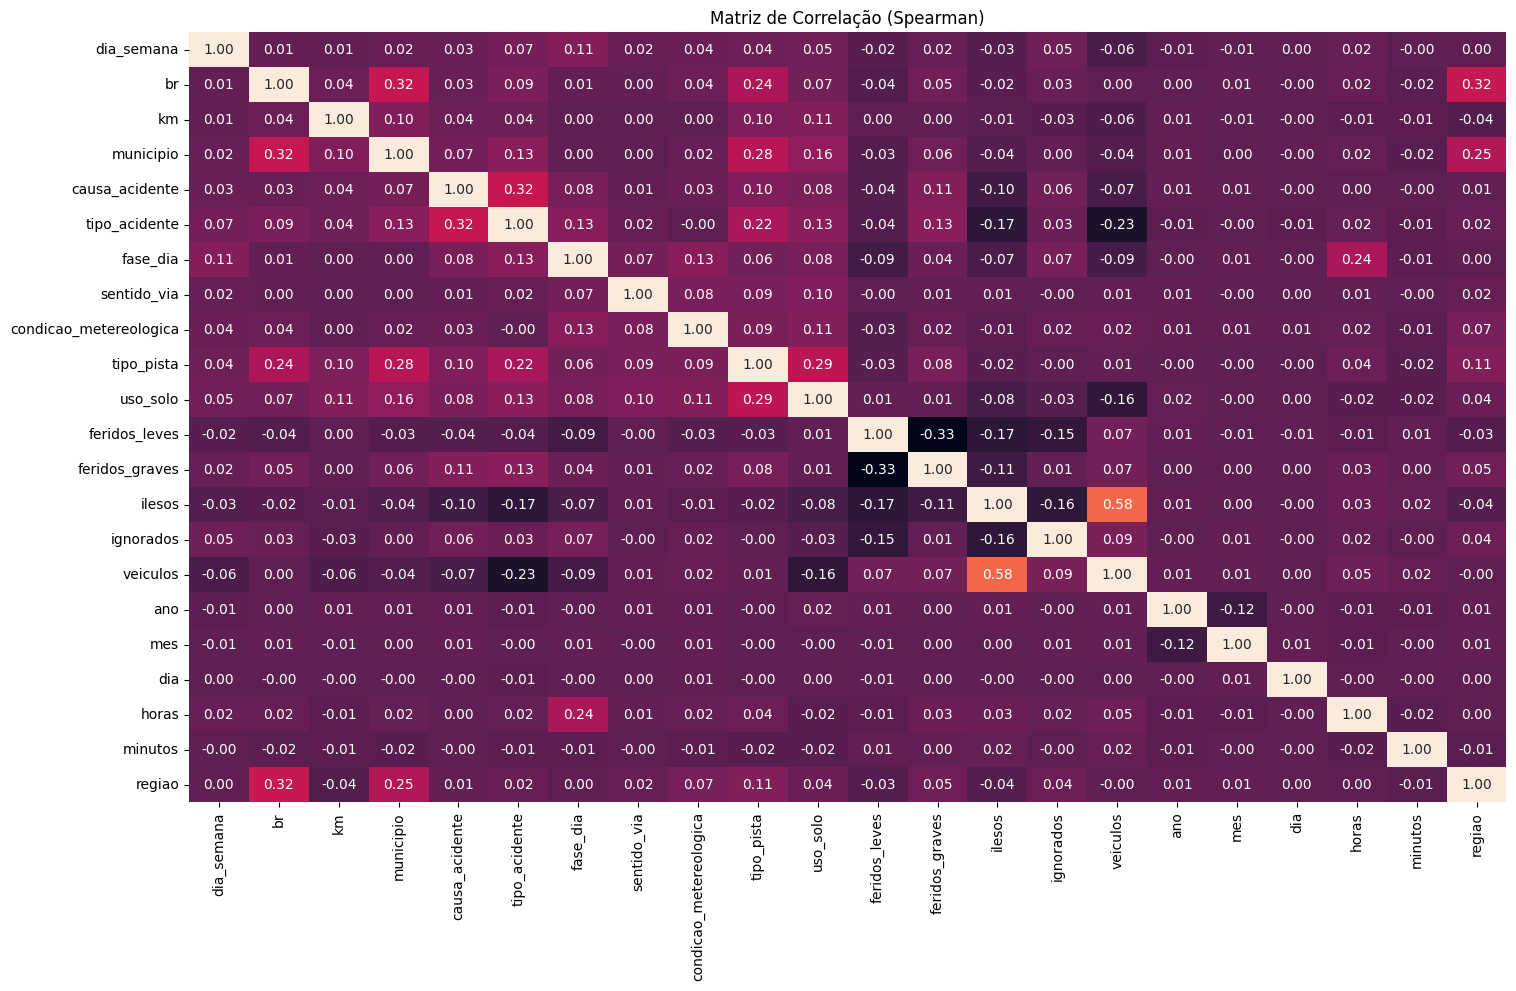

In [40]:
# Correlação por Spearman
matriz = x_train.corr(method = 'spearman')
plt.figure(figsize = (17,10))
sns.heatmap(matriz, annot = True, fmt = '.2f' , cbar = False)
plt.title('Matriz de Correlação (Spearman)')
plt.show()

Para fazer a seleção por correlação, adotarei duas regras para remoção:

1.    Features com correlação igual ou superior a 0.7;
2.    Features com 3 ou mais correlações acima de 0.5.

Como visto pela Matriz de Correlação, as features que se encaixam na filtragem são "uf" e "delegacia".

Obs: A feature "pessoas" é a soma de todas as outras que contabilizam a participação de indivíduos nos acidentes; logo, é ambígua. Portanto, também será removida.

In [39]:
# Remoção das colunas para treino e teste
x_train.drop(['uf','delegacia','pessoas'], axis = 1, inplace= True)
x_test.drop(['uf','delegacia','pessoas'], axis = 1, inplace= True)

## SelectKBest

SelectKBest" é um algoritmo para selecionar features, no qual realiza uma análise de cada uma com à target, em seguida atribui uma pontuação conforme determinada métrica pré-estabelecida e mantém "K" número de variáveis que tiveram o melhor score.

Para o projeto utilizarei a métrica **f_classif**, conhecida para modelos de classifição e que usa ANOVA(Análise de Variância) para medir a pontuação, pois ela sugere o quanto as médias das variáveis ajudam a distinguir entre as diferentes classes.

Como estamos trabalhando com 21 variáveis, pois adotei CatBoostEncoder aos invés de One-Hot ou Get Dummies que gerariam mais colunas. Vou ser mais contido e manterei 2/3 das features.


**Obs**: Não utilizei a métrica chi2(qui-quadro), que também é muito comum em modelos de classificação, pois ela não permite valores negativos, dos quais possuem nos datasets.


In [44]:
# Aplicando o SelectKBest e seus parametros
k_best = SelectKBest(f_classif, k = 14)
k_best.fit(x_train, y_train)
x_train_kbest = k_best.transform(x_train)
x_test_kbest = k_best.transform(x_test)

# Features escolhidas pelo SelectKBest
df_selected_features = pd.DataFrame({'Feature': x_train.columns, 'SelectKBest': k_best.get_support()})
print(df_selected_features)

                   Feature  SelectKBest
0               dia_semana         True
1                       br         True
2                       km         True
3                municipio         True
4           causa_acidente         True
5            tipo_acidente         True
6                 fase_dia         True
7              sentido_via        False
8   condicao_metereologica        False
9               tipo_pista         True
10                uso_solo         True
11           feridos_leves         True
12          feridos_graves         True
13                  ilesos        False
14               ignorados         True
15                veiculos         True
16                     ano        False
17                     mes        False
18                     dia        False
19                   horas        False
20                 minutos        False
21                  regiao         True


# Modelos


## Random Forest (Selectkbest)

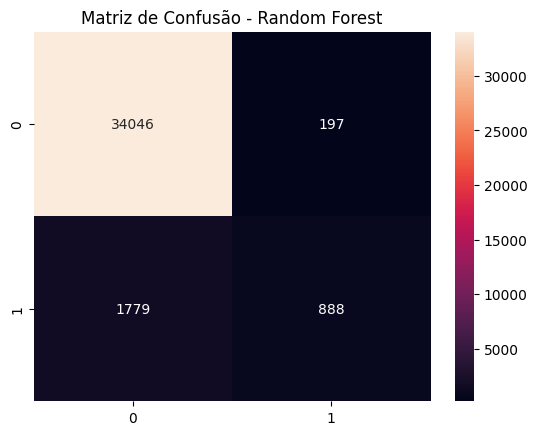

Acurácia: 0.95
Precisão: 0.82
Recall: 0.33
F1-score: 0.47


In [8]:
# Criação do Random Forest com o SelectKbest
model_random = RandomForestClassifier(n_estimators= 100, random_state = 1337)
model_random.fit(x_train_kbest,y_train)
random_predict = model_random.predict(x_test_kbest)

# Availiação do modelo
sns.heatmap(confusion_matrix(y_test, random_predict), annot = True, fmt = 'g')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

accuracy = accuracy_score(y_test, random_predict)
precision = precision_score(y_test, random_predict)
recall = recall_score(y_test, random_predict)
f1 = f1_score(y_test, random_predict)

print(f'Acurácia: {accuracy:.2f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

## K-Nearest Neighbors (KNN)

In [9]:
# Criação do K-Nearest Neighbors com o SelectKbest
model_knn = KNeighborsClassifier(metric = 'minkowski',  n_neighbors = 3)
model_knn.fit(x_train_kbest, y_train)
knn_predict = model_knn.predict(x_test_kbest)

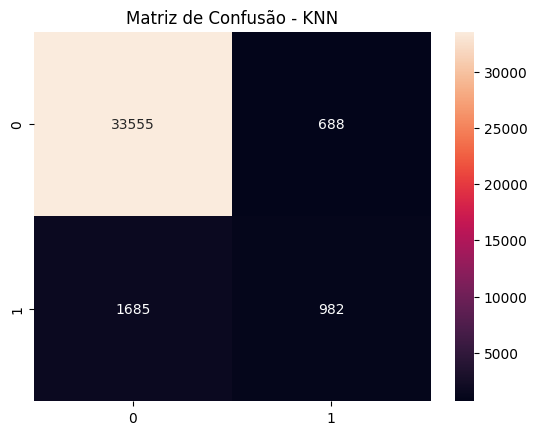

Acurácia: 0.94
Precisão: 0.59
Recall: 0.37
F1-score: 0.45


In [10]:
sns.heatmap(confusion_matrix(y_test,knn_predict), annot = True, fmt = 'g')
plt.title("Matriz de Confusão - KNN")
plt.show()

accuracy = accuracy_score(y_test, knn_predict)
precision = precision_score(y_test, knn_predict)
recall = recall_score(y_test, knn_predict)
f1 = f1_score(y_test, knn_predict)

print(f'Acurácia: {accuracy:.2f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

## Regressão Logistica

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


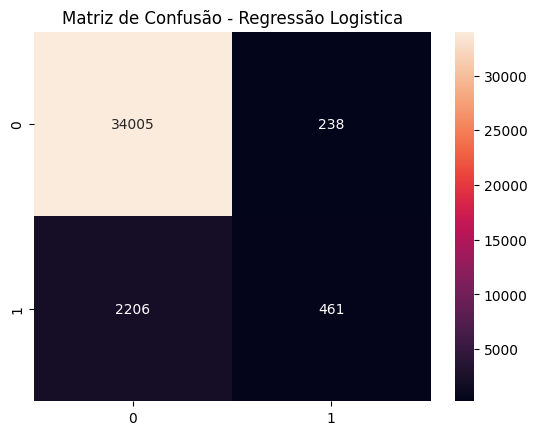

Acurácia: 0.93
Precisão: 0.66
Recall: 0.17
F1-score: 0.27


In [11]:
# Criando o modelo LogisticRegression usando Selectkbest
model_log = LogisticRegression(random_state= 1337 ) # penalty='l1')
model_log.fit(x_train_kbest,y_train)
log_predict = model_log.predict(x_test_kbest)

# Avaliando o modelo de LogisticRegression
sns.heatmap(confusion_matrix(y_test,log_predict), annot = True, fmt = 'g')
plt.title("Matriz de Confusão - Regressão Logistica")
plt.show()

accuracy = accuracy_score(y_test, log_predict)
precision = precision_score(y_test, log_predict)
recall = recall_score(y_test, log_predict)
f1 = f1_score(y_test, log_predict)

print(f'Acurácia: {accuracy:.2f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

## Gradient Boosting Classifier

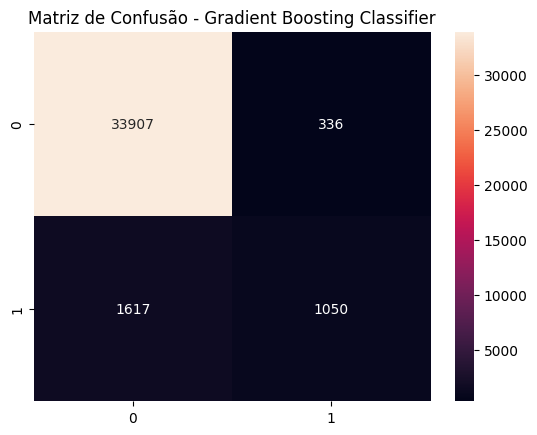

Acurácia: 0.95
Precisão: 0.76
Recall: 0.39
F1-score: 0.52


In [12]:
# Criando o modelo GradientBoostingClassifier com a features do Selectkbest
model_gb = GradientBoostingClassifier(n_estimators = 100 , random_state = 1337, max_depth = 8, learning_rate = 0.1)
model_gb.fit(x_train_kbest, y_train)
gb_predict= model_gb.predict(x_test_kbest)

# Avaliando o modelo de Gradient Boosting Classifier
sns.heatmap(confusion_matrix(y_test,gb_predict), annot = True, fmt = 'g')
plt.title("Matriz de Confusão - Gradient Boosting Classifier")
plt.show()

accuracy = accuracy_score(y_test, gb_predict)
precision = precision_score(y_test, gb_predict)
recall = recall_score(y_test, gb_predict)
f1 = f1_score(y_test, gb_predict)

print(f'Acurácia: {accuracy:.2f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

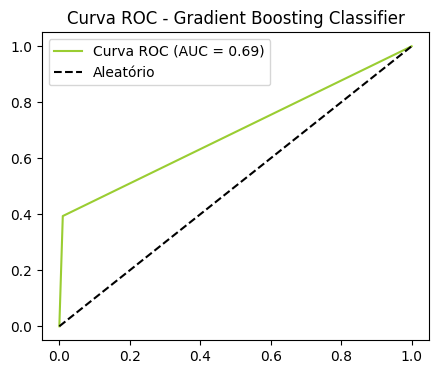

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, gb_predict)

# Calculando a AUC
roc_auc = auc(fpr, tpr)

# Plotando a Curva ROC
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='yellowgreen',  label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black',  linestyle='--', label='Aleatório')
plt.title('Curva ROC - Gradient Boosting Classifier')
plt.legend()
plt.show()

# Modelos com Oversampling

## Random Forest

In [14]:
x_train_smote = df_train_smote.drop('obitos', axis = 1)
y_train_smote = df_train_smote['obitos']

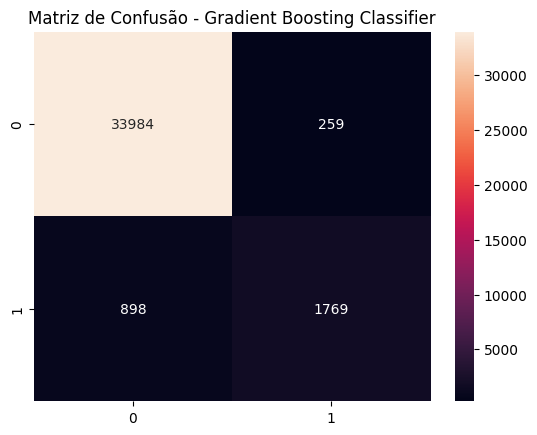

Acurácia: 0.97
Precisão: 0.87
Recall: 0.66
F1-score: 0.75


In [15]:
# Criando RandomForestClassifier com base de oversampling
model_random_smt = RandomForestClassifier(n_estimators= 150, random_state = 1337)
model_random_smt.fit(x_train_smote,y_train_smote)
random_smt_predict = model_random_smt.predict(x_test)

# Avaliando o modelo de Gradient Boosting Classifier
sns.heatmap(confusion_matrix(y_test,random_smt_predict), annot = True, fmt = 'g')
plt.title("Matriz de Confusão - Gradient Boosting Classifier")
plt.show()

accuracy = accuracy_score(y_test, random_smt_predict)
precision = precision_score(y_test, random_smt_predict)
recall = recall_score(y_test, random_smt_predict)
f1 = f1_score(y_test, random_smt_predict)

print(f'Acurácia: {accuracy:.2f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

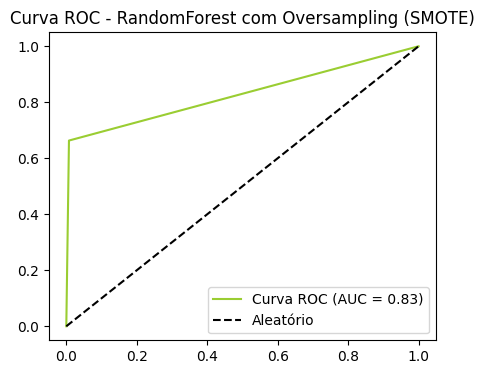

In [16]:
# Curva ROC e AUC
fpr, tpr, thresholds = roc_curve(y_test, random_smt_predict)

# Calculando a AUC
roc_auc = auc(fpr, tpr)

# Plotando a Curva ROC
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='yellowgreen', label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Aleatório')
plt.title('Curva ROC - RandomForest com Oversampling (SMOTE)')
plt.legend()
plt.show()

In [17]:
# Cross Validation
#socres = cross_val_score(model_random_smt,x_train_smote, y_train_smote, cv = 5 , scoring = 'f1')

## KNN

In [18]:
model_knn_smt = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
model_knn_smt.fit(x_train_smote,y_train_smote)
knn_smt_predict = model_knn_smt.predict(x_test)

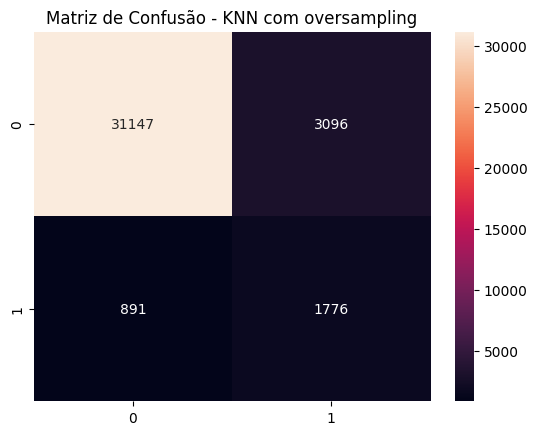

Acurácia: 0.89
Precisão: 0.36
Recall: 0.67
F1-score: 0.47


In [19]:
# Avaliando o modelo de K-Nearest Neighbors (KNN) como oversampling
sns.heatmap(confusion_matrix(y_test,knn_smt_predict), annot = True, fmt = 'g')
plt.title("Matriz de Confusão - KNN com oversampling")
plt.show()

accuracy = accuracy_score(y_test, knn_smt_predict)
precision = precision_score(y_test, knn_smt_predict)
recall = recall_score(y_test, knn_smt_predict)
f1 = f1_score(y_test, knn_smt_predict)

print(f'Acurácia: {accuracy:.2f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

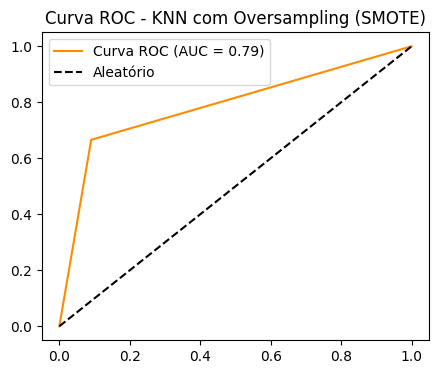

In [20]:
# Curva ROC e AUC
fpr, tpr, thresholds = roc_curve(y_test, knn_smt_predict)

# Calculando a AUC
roc_auc = auc(fpr, tpr)

# Plotando a Curva ROC
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Aleatório')
plt.title('Curva ROC - KNN com Oversampling (SMOTE)')
plt.legend()
plt.show()

## Gradient Boosting Classifier

In [21]:
# Criando o modelo GradientBoostingClassifier com a features do Selectkbest
model_gb_smt = GradientBoostingClassifier(n_estimators = 25 , random_state = 1337, max_depth = 5, learning_rate = 0.1)
model_gb_smt.fit(x_train_smote, y_train_smote)
gb_smt_predict= model_gb_smt.predict(x_test)

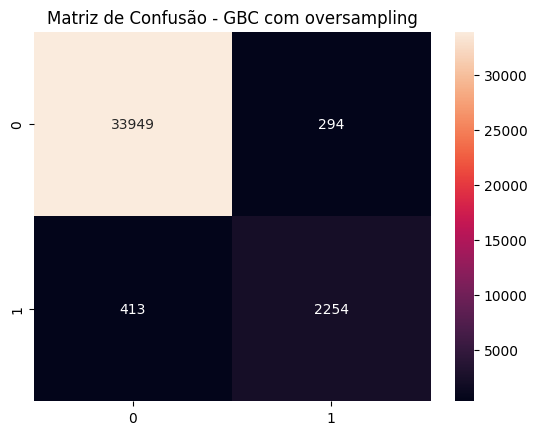

Acurácia: 0.98
Precisão: 0.88
Recall: 0.85
F1-score: 0.86


In [22]:
# Avaliando o modelo de GradientBoostingClassifier com dados sinteticos
sns.heatmap(confusion_matrix(y_test,gb_smt_predict), annot = True, fmt = 'g')
plt.title("Matriz de Confusão - GBC com oversampling")
plt.show()

accuracy = accuracy_score(y_test, gb_smt_predict)
precision = precision_score(y_test, gb_smt_predict)
recall = recall_score(y_test, gb_smt_predict)
f1 = f1_score(y_test, gb_smt_predict)

print(f'Acurácia: {accuracy:.2f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

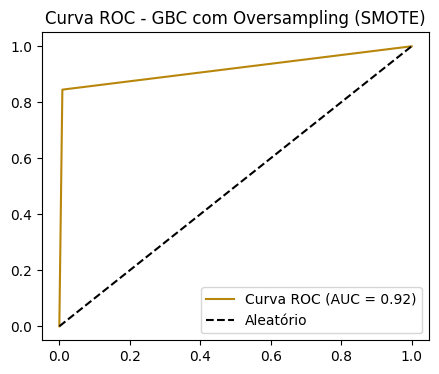

In [23]:
# Curva ROC e AUC
fpr, tpr, thresholds = roc_curve(y_test, gb_smt_predict)

# Calculando a AUC
roc_auc = auc(fpr, tpr)

# Plotando a Curva ROC
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkgoldenrod', label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Aleatório')
plt.title('Curva ROC - GBC com Oversampling (SMOTE)')
plt.legend()
plt.show()

## Regressão Logistica

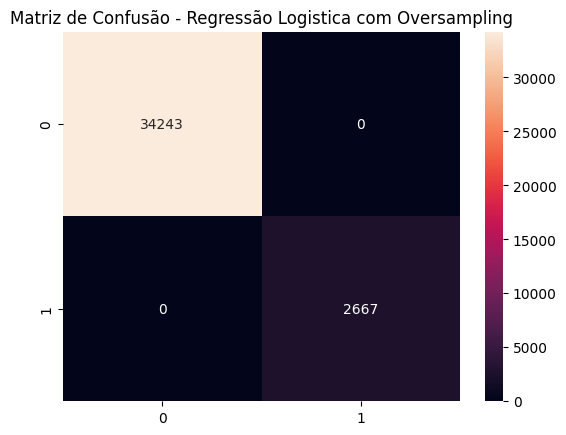

Acurácia: 1.00
Precisão: 1.00
Recall: 1.00
F1-score: 1.00


In [24]:
# Criando o modelo LogisticRegression usando Oversampling
model_log_smt = LogisticRegression(random_state= 1337 ) # penalty='l1')
model_log_smt.fit(x_train_smote,y_train_smote)
log_predict_smt = model_log_smt.predict(x_test)

# Avaliando o modelo de LogisticRegression
sns.heatmap(confusion_matrix(y_test,log_predict_smt), annot = True, fmt = 'g')
plt.title("Matriz de Confusão - Regressão Logistica com Oversampling")
plt.show()

accuracy = accuracy_score(y_test, log_predict_smt)
precision = precision_score(y_test, log_predict_smt)
recall = recall_score(y_test, log_predict_smt)
f1 = f1_score(y_test, log_predict_smt)

print(f'Acurácia: {accuracy:.2f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')